# Imports

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import timm

# Config

In [2]:
class CFG:
    seed = 888
    debug = False
    one_fold = False
    base_dir = pathlib.Path("/kaggle/input/hms-harmful-brain-activity-classification")
    path_train = base_dir / "train.csv"
    spec_dir = base_dir / "train_spectrograms"
    transform = transforms.Resize((512, 512), antialias=False)
    model_name = "tf_efficientnet_b0_ns"
    n_fold = 5
    epochs = 6
    batch_size = 10    
    lr = 0.001

# Load data
- We classify the spectrogram directly.
- As a label we use the aggregated the votes per spectrogram slice

In [3]:
train_df = pd.read_csv("/kaggle/input/hms-harmful-brain-activity-classification/train.csv")
train_df

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106795,351917269,6,12.0,2147388374,6,12.0,4195677307,10351,LRDA,0,0,0,3,0,0
106796,351917269,7,14.0,2147388374,7,14.0,290896675,10351,LRDA,0,0,0,3,0,0
106797,351917269,8,16.0,2147388374,8,16.0,461435451,10351,LRDA,0,0,0,3,0,0
106798,351917269,9,18.0,2147388374,9,18.0,3786213131,10351,LRDA,0,0,0,3,0,0


In [4]:
label_columns = train_df.filter(like="_vote").columns.to_list()
label_columns

['seizure_vote',
 'lpd_vote',
 'gpd_vote',
 'lrda_vote',
 'grda_vote',
 'other_vote']

In [5]:
data = train_df.groupby("spectrogram_id")[label_columns].sum()
n = data.sum(axis=1)
for x in label_columns:
    data[x] = data[x] / n
data["path"] = data.index.map(lambda x: CFG.spec_dir / f"{x}.parquet")
data = data.reset_index()
data

,spectrogram_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,path
0,353733,1.000000,0.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
1,924234,0.000000,0.0000,0.454545,0.000000,0.090909,0.454545,/kaggle/input/hms-harmful-brain-activity-class...
2,999431,0.000000,0.0625,0.000000,0.875000,0.000000,0.062500,/kaggle/input/hms-harmful-brain-activity-class...
3,1084844,0.000000,0.0000,0.000000,1.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
4,1219001,0.677419,0.0000,0.322581,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
...,...,...,...,...,...,...,...,...
11133,2146188334,0.000000,0.0000,0.000000,0.000000,0.000000,1.000000,/kaggle/input/hms-harmful-brain-activity-class...
11134,2146414988,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...
11135,2146798838,0.000000,0.5000,0.000000,0.111111,0.000000,0.388889,/kaggle/input/hms-harmful-brain-activity-class...
11136,2147312808,0.000000,1.0000,0.000000,0.000000,0.000000,0.000000,/kaggle/input/hms-harmful-brain-activity-class...


# Data Handling
- Spectrogram is loaded, which contains spectrograms in 4 different regions.
- All together they are clipped, log-transformed and the standardized.
- Finally it is resized as an image.
- Note, since the spectrograms have sometimes very different lenghts this creates a certain distortion.

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
def preprocess(x):
    x = np.clip(x, np.exp(-6), np.exp(10))
    x = np.log(x)
    m, s = x.mean(), x.std()
    x = (x - m) / (s + 1e-6)
    return x


class SpecDataset(Dataset):
    
    def __init__(self, df, transform=CFG.transform):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        # input
        x = pd.read_parquet(row.path)
        x = x.fillna(-1).values[:, 1:].T
        x = preprocess(x)
        x = torch.Tensor(x[None, :])
        if self.transform:
            x = self.transform(x)
        # output
        y = np.array(row.loc[label_columns].values, 'float32')
        y = torch.Tensor(y)
        return x, y

In [8]:
ds = SpecDataset(df=data.iloc[:50])
ds, len(ds)

(<__main__.SpecDataset at 0x7af2fa173df0>, 50)

In [9]:
x, y = ds[0]
x.shape, x, y.shape, y

(torch.Size([1, 512, 512]),
 tensor([[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
          [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
          [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
          ...,
          [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
          [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
          [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]]),
 torch.Size([6]),
 tensor([1., 0., 0., 0., 0., 0.]))

In [10]:
ld = DataLoader(dataset=ds, batch_size=CFG.batch_size, drop_last=True, num_workers=os.cpu_count())
ld, len(ld)

(<torch.utils.data.dataloader.DataLoader at 0x7af2fa1fbd90>, 5)

In [11]:
x, y = next(iter(ld))
x.shape, x, y.shape, y

(torch.Size([10, 1, 512, 512]),
 tensor([[[[ 1.2054,  1.0713,  0.9173,  ...,  1.0850,  1.0003,  0.9526],
           [ 1.6161,  1.3790,  1.0838,  ...,  1.1306,  1.0802,  1.0625],
           [ 1.7601,  1.6410,  1.4847,  ...,  1.2272,  1.1640,  1.1396],
           ...,
           [-0.8010, -0.6403, -0.4212,  ..., -0.8658, -1.1458, -1.3737],
           [-0.7389, -0.5765, -0.3597,  ..., -0.8116, -1.2053, -1.5185],
           [-0.8025, -0.5923, -0.3145,  ..., -0.8211, -1.2874, -1.6645]]],
 
 
         [[[ 1.8998,  1.8514,  1.7770,  ...,  1.5049,  1.6229,  1.6995],
           [ 1.9068,  1.8645,  1.7993,  ...,  1.5456,  1.6550,  1.7260],
           [ 1.9491,  1.8969,  1.8166,  ...,  1.5353,  1.6585,  1.7386],
           ...,
           [-0.9747, -0.9018, -0.7895,  ..., -1.1577, -1.2446, -1.3011],
           [-0.9120, -0.8630, -0.7876,  ..., -1.2038, -1.3935, -1.5167],
           [-0.7837, -0.7837, -0.7837,  ..., -1.0045, -1.5825, -1.9580]]],
 
 
         [[[ 1.1971,  1.0295,  0.7975,  ...,  1.

# Model

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"DEVICE: {DEVICE}")

DEVICE: cuda


In [13]:
torch.cuda.memory_allocated()

0

In [14]:
## Alternative in timm
# model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
# model.to(DEVICE)
# num_parameter = sum(x.numel() for x in model.parameters())
# print(f"Model has {num_parameter} parameters.")

In [15]:
import torch
from torchvision import models

model = models.resnet18(pretrained=True)

model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

num_classes = 6
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Calculate the number of parameters
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model 'resnet18' has {num_parameters} parameters.")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 139MB/s]


Model 'resnet18' has 11173318 parameters.


In [16]:
y_out = model(x.to(DEVICE))
y_out

tensor([[ 0.7982, -0.6452,  1.1883,  0.2184,  0.0896, -0.1548],
        [ 0.5998, -0.1623,  1.0377,  0.0615,  0.2533,  0.3305],
        [ 0.5760, -0.6669,  1.0932, -0.1739,  0.2232, -0.0940],
        [ 0.8280,  0.0863,  0.9390, -0.3429,  0.0834,  0.4169],
        [ 0.3596,  0.1298,  0.9796,  0.0245,  0.4703,  0.2321],
        [ 0.4997, -0.0770,  1.0289, -0.5017, -0.4273,  0.3928],
        [ 0.7053,  0.2634,  1.1172, -0.2667, -0.2186, -0.5256],
        [ 0.4955, -0.0472,  0.9358, -0.7652, -0.4970, -0.0033],
        [ 0.6550, -0.0707,  1.0994, -0.2685, -0.1261,  0.3620],
        [ 0.5394, -0.3985,  0.5090,  0.1452,  0.2737,  0.2231]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

# Training Utils
- Create Kullback-Leibler Divergence loss from logits.
- Compute loss utility.

In [17]:
def KLDivLoss(logit, target):
    log_prob = F.log_softmax(logit, dim=1)
    return F.kl_div(log_prob, target, reduction="batchmean")

In [18]:
# from reference
def KL_loss(p,q):
    epsilon=10**(-15)
    p=torch.clip(p,epsilon,1-epsilon)
    q = nn.functional.log_softmax(q,dim=1)
    return torch.mean(torch.sum(p*(torch.log(p)-q),dim=1))

In [19]:
KLDivLoss(y_out, y.to(DEVICE)), KL_loss(p=y.to(DEVICE), q=y_out)

(tensor(1.3892, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(1.3892, device='cuda:0', grad_fn=<MeanBackward0>))

In [20]:
def compute_loss(model, data_loader):
    model.eval()
    l_loss = []
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x.to(DEVICE))
            loss = KLDivLoss(y_pred, y.to(DEVICE))
            l_loss.append(loss.item())
    return np.mean(l_loss) 

In [21]:
compute_loss(model, ld)

1.5651319026947021

In [22]:
torch.cuda.memory_allocated()

1192086528

In [23]:
del model, x, y, y_out
torch.cuda.empty_cache()

In [24]:
torch.cuda.memory_allocated()

1192076288

# Training
- Uses plain 5 fold training strategy.
- Runs for all epochs and checkpoints model weights if the validation loss improves.

In [25]:
from sklearn.model_selection import KFold

In [26]:
if CFG.debug:
    data = data.iloc[:400]

Fold 0:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.930820, Valid Loss:   0.900335
Loss improves from        inf to   0.900335


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.676155, Valid Loss:   0.642602
Loss improves from   0.900335 to   0.642602


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.603772, Valid Loss:   0.614464
Loss improves from   0.642602 to   0.614464


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.533866, Valid Loss:   0.574079
Loss improves from   0.614464 to   0.574079


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.502962, Valid Loss:   0.589104


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.447780, Valid Loss:   0.626253

Best loss Model training with 0.5740788641130977



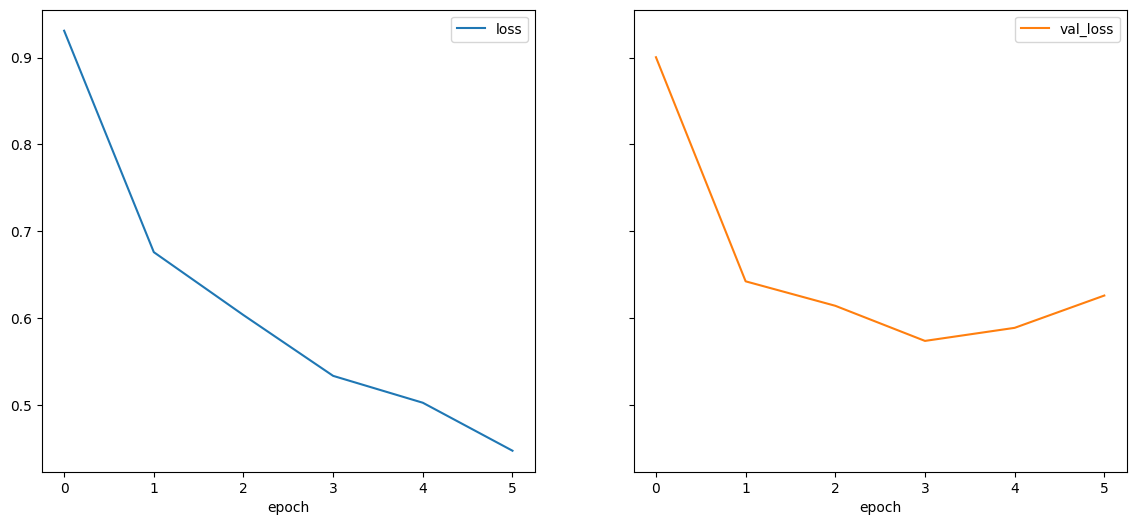

Fold 1:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.934356, Valid Loss:    0.82898
Loss improves from        inf to    0.82898


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.672688, Valid Loss:   0.634486
Loss improves from   0.828980 to   0.634486


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.601861, Valid Loss:   0.637209


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.546944, Valid Loss:   0.633927
Loss improves from   0.634486 to   0.633927


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.496855, Valid Loss:   0.603537
Loss improves from   0.633927 to   0.603537


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.448156, Valid Loss:   0.637509

Best loss Model training with 0.6035368414136326



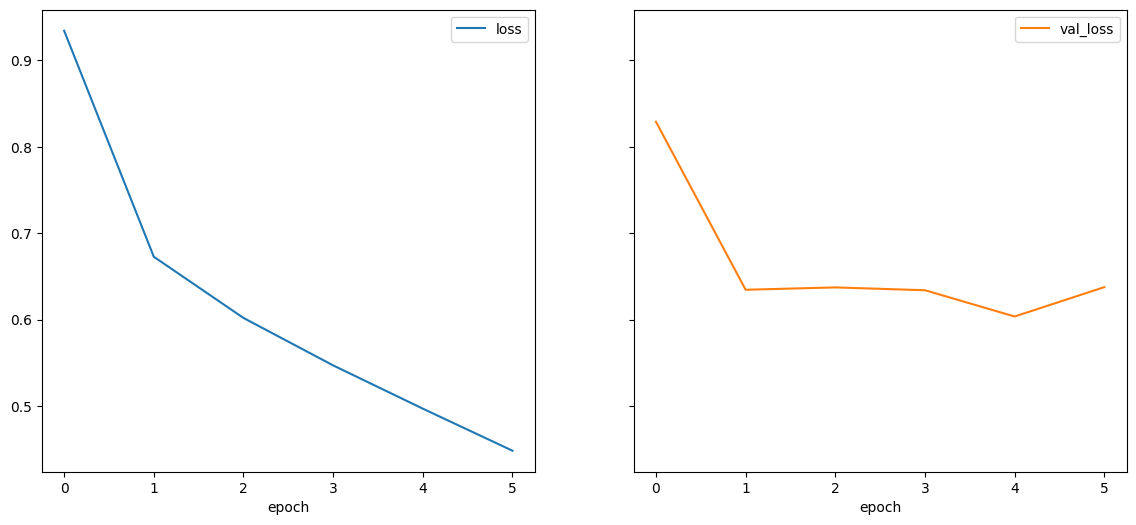

Fold 2:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.917275, Valid Loss:   0.909006
Loss improves from        inf to   0.909006


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.679268, Valid Loss:   0.659969
Loss improves from   0.909006 to   0.659969


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.599975, Valid Loss:   0.591501
Loss improves from   0.659969 to   0.591501


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.551420, Valid Loss:    0.62033


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.499267, Valid Loss:   0.615396


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.447933, Valid Loss:   0.613568

Best loss Model training with 0.5915008766635117



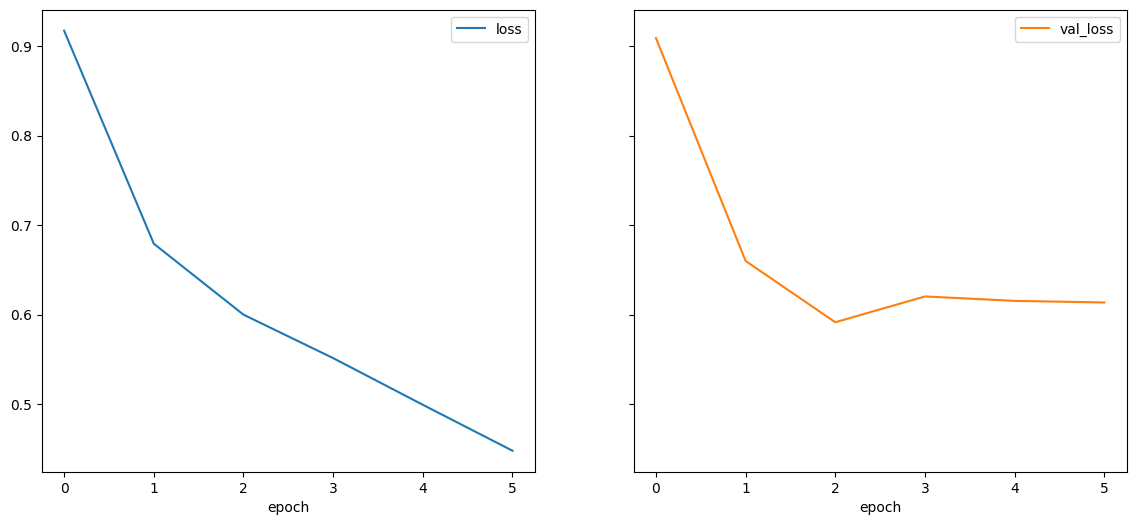

Fold 3:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.931714, Valid Loss:   0.727641
Loss improves from        inf to   0.727641


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.674662, Valid Loss:   0.648359
Loss improves from   0.727641 to   0.648359


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.603017, Valid Loss:   0.679856


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.541391, Valid Loss:   0.644405
Loss improves from   0.648359 to   0.644405


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.492335, Valid Loss:   0.579946
Loss improves from   0.644405 to   0.579946


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.450837, Valid Loss:   0.588633

Best loss Model training with 0.5799460873809631



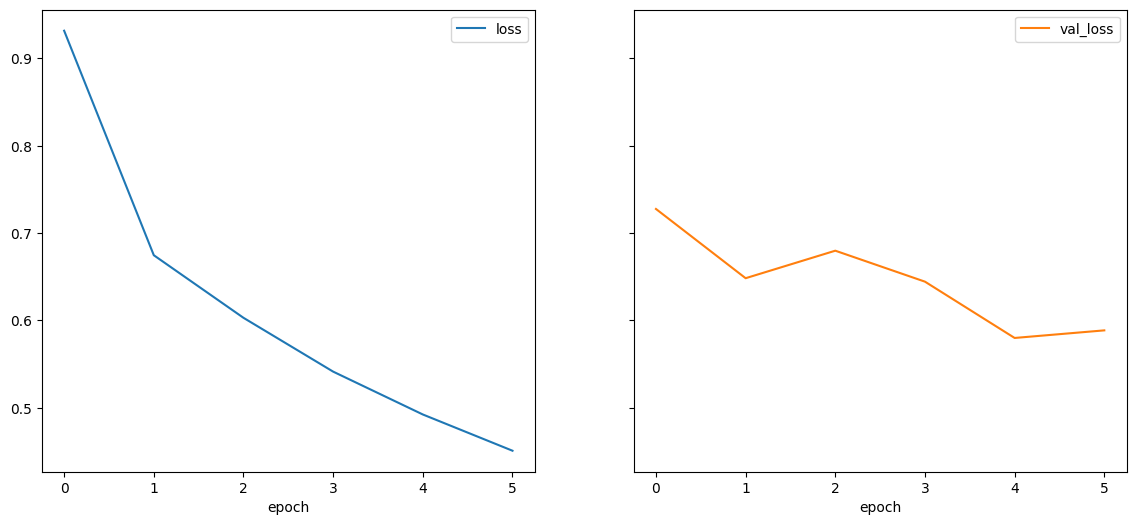

Fold 4:


/opt/conda/lib/python3.10/site-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 0
Train Loss:   0.922466, Valid Loss:    0.73132
Loss improves from        inf to    0.73132


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 1
Train Loss:   0.677335, Valid Loss:   0.617405
Loss improves from   0.731320 to   0.617405


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 2
Train Loss:   0.611469, Valid Loss:   0.586669
Loss improves from   0.617405 to   0.586669


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 3
Train Loss:   0.555367, Valid Loss:   0.554291
Loss improves from   0.586669 to   0.554291


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 4
Train Loss:   0.511296, Valid Loss:   0.585354


  0%|          | 0/891 [00:00<?, ?it/s]

Epoch 5
Train Loss:   0.462946, Valid Loss:   0.567189

Best loss Model training with 0.5542906523419068



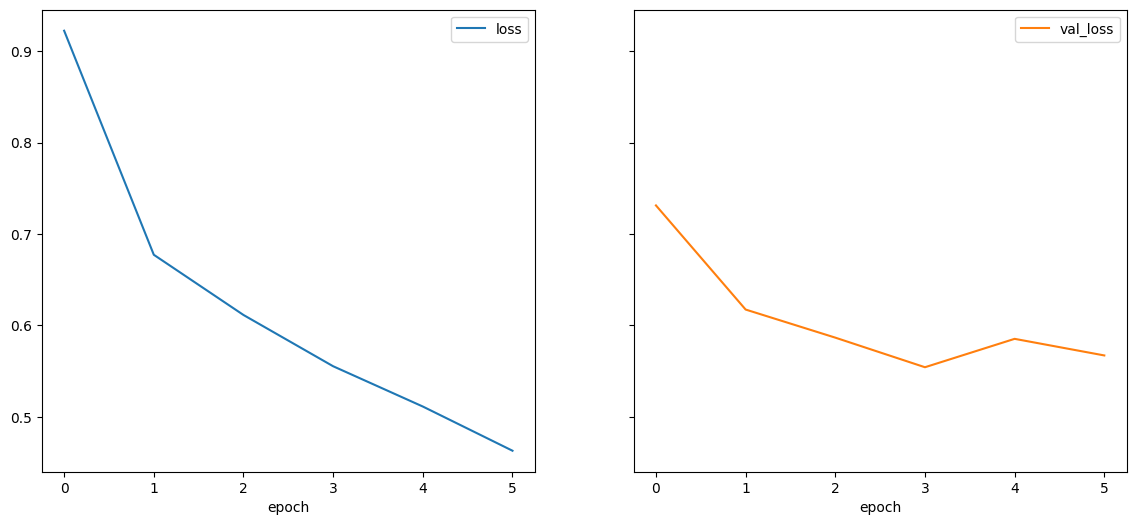

CPU times: user 1h 38min 29s, sys: 3min 15s, total: 1h 41min 45s
Wall time: 2h 10min 51s


In [27]:
%%time

kf = KFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

l_best_loss = []
for fold, (iloc_train, iloc_valid) in enumerate(kf.split(data)):
    print(f"Fold {fold}:")

    # prepare data
    train_ds = SpecDataset(df=data.iloc[iloc_train])
    valid_ds = SpecDataset(df=data.iloc[iloc_valid])
    train_loader = DataLoader(dataset=train_ds, shuffle=True, batch_size=CFG.batch_size, num_workers=os.cpu_count(), drop_last=True)
    valid_loader = DataLoader(dataset=valid_ds, batch_size=CFG.batch_size, num_workers=os.cpu_count())
    
    # init training
    model = timm.create_model(model_name=CFG.model_name, pretrained=True, num_classes=6, in_chans=1)
    model.to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=CFG.lr)
    scheduler = CosineAnnealingLR(optimizer=optimizer, T_max=CFG.epochs)
    optimizer, scheduler
    best_loss = float("inf")
    history = []
    
    # run training
    for epoch in tqdm(range(CFG.epochs)):
        model.train()
        l_loss = []
        for x, y in tqdm(train_loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            y_pred = model(x)
            loss = KLDivLoss(y_pred, y)
            l_loss.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        train_loss = np.mean(l_loss)
        valid_loss = compute_loss(model, valid_loader)
        history.append((epoch, train_loss, valid_loss))
        print(f"Epoch {epoch}")
        print(f"Train Loss: {train_loss:>10.6f}, Valid Loss: {valid_loss:>10.6}")
        if valid_loss < best_loss:
            print(f"Loss improves from {best_loss:>10.6f} to {valid_loss:>10.6}")
            torch.save(model.state_dict(), f"{CFG.model_name}__{fold}.pt")
            best_loss = valid_loss
    print(f"\nBest loss Model training with {best_loss}\n")
    l_best_loss.append(best_loss)
    
    # plot
    history = pd.DataFrame(history, columns=["epoch", "loss", "val_loss"]).set_index("epoch")
    history.plot(subplots=True, layout=(1, 2), sharey="row", figsize=(14, 6))
    plt.show()
    
    if CFG.one_fold:
        break

# OOF

In [28]:
l_best_loss, np.mean(l_best_loss)

([0.5740788641130977,
  0.6035368414136326,
  0.5915008766635117,
  0.5799460873809631,
  0.5542906523419068],
 0.5806706643826224)

In [29]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
            #    accuracy_fn,
               device: torch.device = device):
    train_loss, train_hits, train_acc, all_y_true, all_y_pred = 0, 0, 0, [], []
    model.to(device)
    model.train()
    
    for batch in dataloader:
        X, y = batch
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels
        train_loss += loss
        train_acc += acc
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [30]:
def test_step(dataloader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for batch in dataloader:
            X, y = batch
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [31]:
from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start = timer()


def train(model: torch.nn.Module,
         train_data: torch.utils.data.DataLoader,
         test_data: torch.utils.data.DataLoader,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
        #  accuracy_fn,
         epochs: int,
         device:torch.device = device,
         model_loss_and_acc: pd.DataFrame = None):

   if model_loss_and_acc is None:
       model_loss_and_acc = pd.DataFrame(columns=['train_loss', 'train_acc', 'test_loss', 'test_acc', "f1_score"])

   for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                     data_loader=train_data,
                                     loss_fn=loss_fn,
                                     optimizer=optimizer,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)
        test_loss, test_acc, f1_score = test_step(model=model,
                                     data_loader=test_data,
                                     loss_fn=loss_fn,
                                    #  accuracy_fn=accuracy_fn,
                                     device=device)

        new_row = pd.Series({'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc, "f1_score": f1_score})
        model_loss_and_acc.loc[len(model_loss_and_acc.index)] = new_row

   train_time_end = timer()
   print(f"\nTraining was done in {(train_time_end - train_time_start):.5f} seconds")

   return model_loss_and_acc

In [32]:
metrics = train